# Trading Anomaly Detection with Gaussian Mixture Model - Part 1

## Motivation

Imagine we are running a financial platform where investors can trade things. 

Most of the transactions are fine, but some are strange like trying to sell something for close to nothing; or sudden spike in activity frequency to machine level 10 transactions per second for instance; or client's IP address trading from Lagos one minute and from Buenos Aires the next.

We want to be notified of such *strange* transactions. We could obviously come up with a set of rules and grow them as we go, but we will try and use machine learning for this.

## Part 1
In general we'll train a `GMM` (from `sklearn.mixture`) to work on a large number of features in an unsupervised fashion.

In part 1 we'll get our hands on the `GMM` model and see how it works on a randomly generated data set.

In [1]:
import numpy as np
import sklearn as sk
from sklearn import mixture
import pandas as pd
%pylab inline

pd.set_option('display.mpl_style', 'default')
plt.rcParams["figure.figsize"] = (18,4)

Populating the interactive namespace from numpy and matplotlib


# Visualisation and first fitting attempt
We'll start by generating some data, visualising it and fitting the first model.

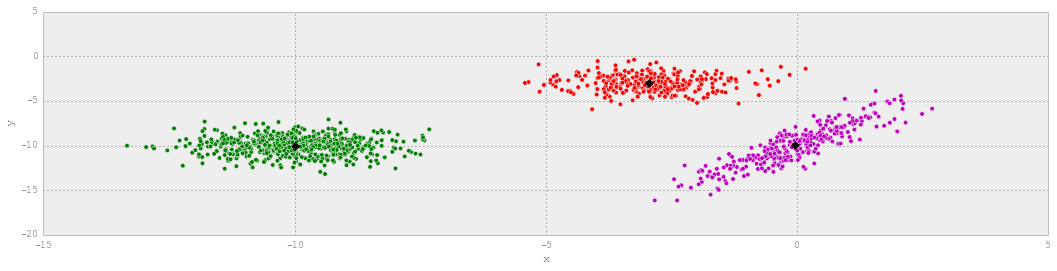

In [2]:

m=300
df1 = pd.DataFrame(random.randn(m,2)-3, columns=['x','y'])
df1['series']=0
df2 = pd.DataFrame(random.randn(m*2,2)-10, columns=['x','y'])
df2['series']=1
df3 = pd.DataFrame(random.randn(m,2), columns=['x','y'])
df3['series']=2
df3.y=df3.x*2-10 + random.randn(m)

df = df1.append(df2).append(df3)
org_df = df
ax = df[df.series==0].plot(kind='scatter', x='x', y='y',color='r')
df[df.series==1].plot(kind='scatter', x='x', y='y',color='g',ax=ax)
df[df.series==2].plot(kind='scatter', x='x', y='y',color='m',ax=ax)

model = mixture.GMM(3)
model.fit(df[['x','y']])
plt.plot(model.means_[:,0], model.means_[:,1], 'kD')

The `means` have fitted nicely (check the black dots in the middle of the clusters). And remember - we only had to tell the model to look for 3 clusters.

# Classification

Let's visualise how the model classifies a uniform grid of points.

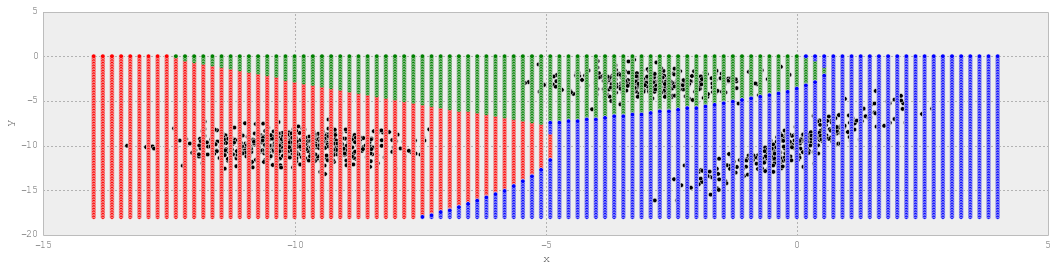

In [3]:
ax = df.plot(kind='scatter', x='x', y='y',color='k')
n_samples=100
xtest=[[x,y] for x in np.linspace(-14,4,n_samples) for y in np.linspace(-18,0,n_samples)]
dfxtest=pd.DataFrame(xtest, columns=['x','y'])
ypred=model.predict(xtest)

dfxtest[ypred==0].plot(kind='scatter', x='x', y='y', color='r', ax=ax)
dfxtest[ypred==1].plot(kind='scatter', x='x', y='y', color='g', ax=ax)
dfxtest[ypred==2].plot(kind='scatter', x='x', y='y', color='b', ax=ax)


It nicely shows which points are actually assigned to which categories. So the model works, but we're after detecting anomalies and not classifying points.

---

# Choosing model args to find anomalies

We'll have a look at the score - which should allow us to draw probability regions which in turn will tell us what is *normal* and what is *strange*. This will allow us to choose the appropriate model parameters, that fit the data best.

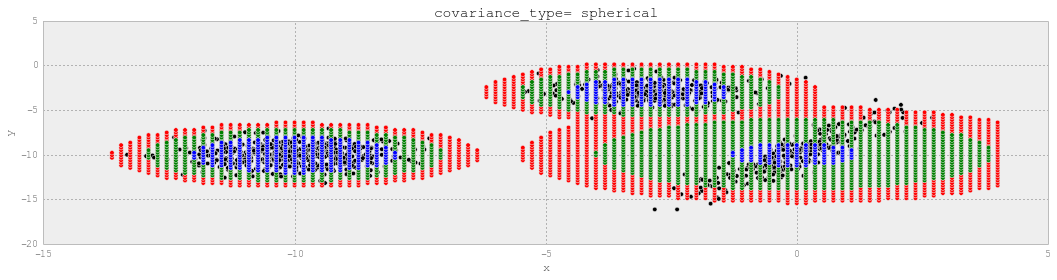

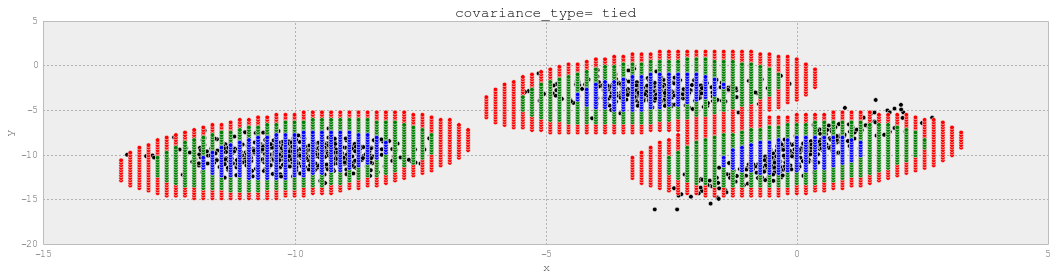

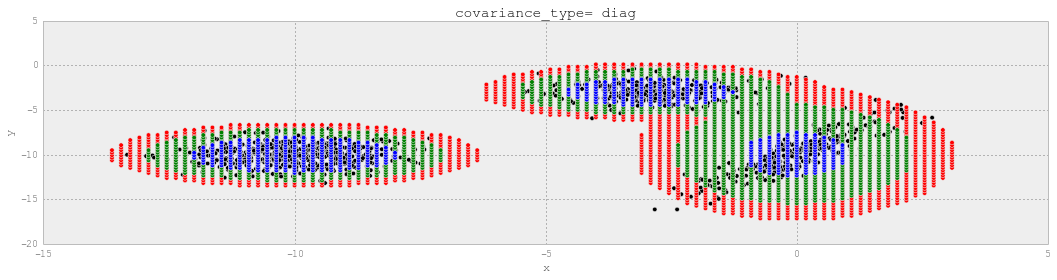

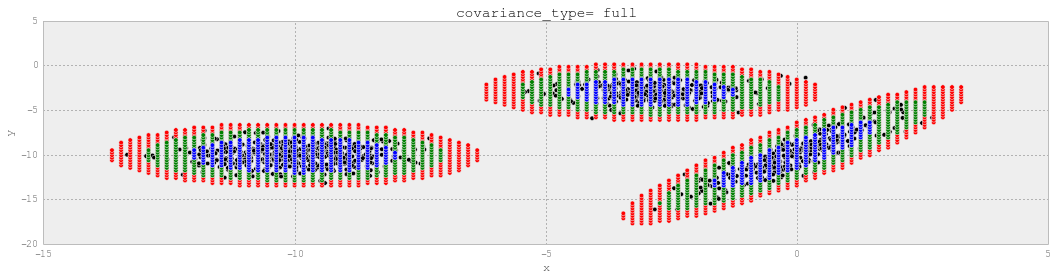

In [4]:

def plot_ranges(df,model,prob=[1e-4,1e-3,1e-2],colors=['r','g','b'], title=''):
    '''Scores the given set of points and plots the defined ranges in various colors'''
    ax = df.plot(kind='scatter', x='x', y='y',color='k')
    ax.set_title(title)
    n_samples=100
    xtest=[[x1,y1] for x1 in np.linspace(-14,4,n_samples) for y1 in np.linspace(-18,10,n_samples)]
    dfxtest=pd.DataFrame(xtest, columns=['x','y'])
    ypred=model.score(xtest)
    for i in np.arange(len(prob)):
        dfxtest[exp(ypred)>=prob[i]].plot(kind='scatter', x='x', y='y', color=colors[i], ax=ax)

def plot_by_type(types):
    for cov_type in types:

        model = mixture.GMM(3, covariance_type=cov_type)
        model.fit(df[['x','y']])

        plot_ranges(df, model, title='covariance_type= {}'.format(cov_type))

plot_by_type(['spherical', 'tied', 'diag', 'full'])

So it looks like `full` setting matches our dataset best. Not surprising given we're using data generated from a (multivariate) normal distribution.


# Does it matter if we increase the training set?

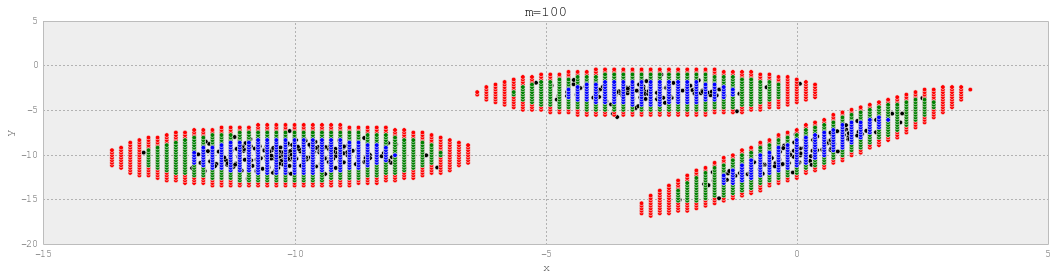

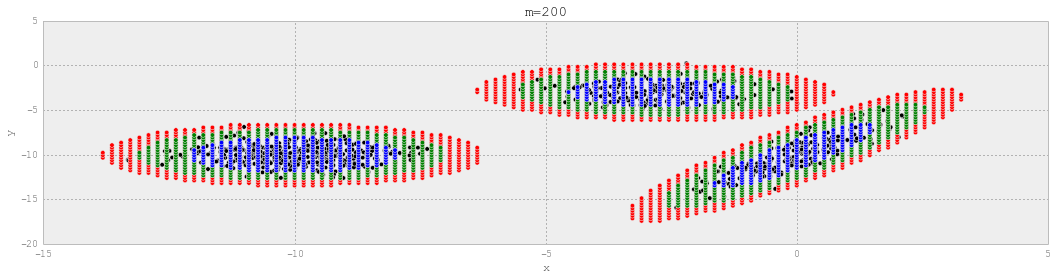

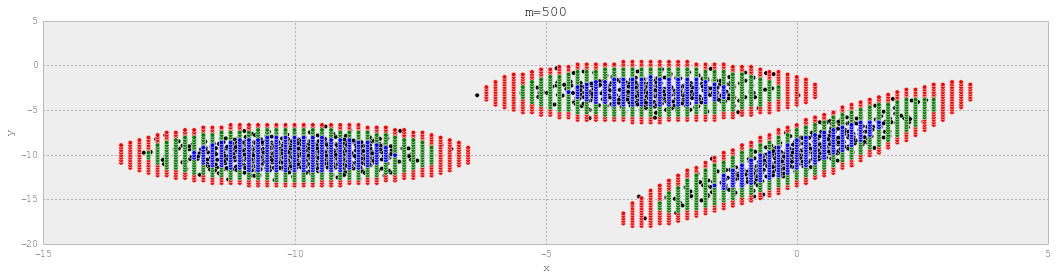

In [5]:

for m in [100, 200, 500]:
    df1 = pd.DataFrame(random.randn(m,2)-3, columns=['x','y'])
    df1['series']=0
    df2 = pd.DataFrame(random.randn(m*2,2)-10, columns=['x','y'])
    df2['series']=1
    df3 = pd.DataFrame(random.randn(m,2), columns=['x','y'])
    df3['series']=2
    df3.y=df3.x*2-10 + random.randn(m)

    df = df1.append(df2).append(df3)

    model = mixture.GMM(3, covariance_type='full')
    model.fit(df[['x','y']])

    plot_ranges(df, model, title='m={}'.format(m))
    


So it seems that the order of magnitude of score doesn't really change with the number of training samples. This is good. So should we focus on `exp(score)=1e-04`?

Well, that seems a bit out of the cuff. Maybe we should ask a different question: **'How many false positives do we want to get per day'**? After all someone will have to validate those manually. We'll calculate it using the appropriate percentile of the scored original data.

# The final model

probability limit for 10.0 false positives in the training set is equal to 0.000427117665665
Detected anomalies in the training set:             x          y
174  0.025705  -3.842986
196 -0.971178  -5.548068
295 -4.012809  -5.944417
425 -6.766830 -10.935261
142 -3.706604 -17.031161
156 -2.575555 -13.385995
223 -2.805688 -14.229730
269 -2.896590 -18.039671
277  3.073787  -1.967265
295 -2.068755 -10.894435


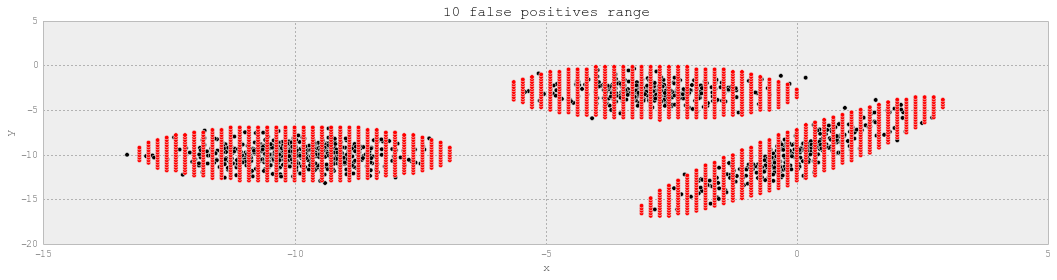

In [6]:
def get_train_data(m):
    df1 = pd.DataFrame(random.randn(m,2)-3, columns=['x','y'])
    df2 = pd.DataFrame(random.randn(m*2,2)-10, columns=['x','y'])
    df3 = pd.DataFrame(random.randn(m,2), columns=['x','y'])
    df3.y=df3.x*2-10 + random.randn(m)
    return df1.append(df2).append(df3)
    
def train_anomaly_model(df):
    model = mixture.GMM(3, covariance_type='full')
    model.fit(df[['x','y']])
    return model

def find_anomaly_limit(model, df, n_falsePositives):
    scores=model.score(df[['x','y']])

    percentile=100*(n_falsePositives / len(scores))

    return np.percentile(np.exp(scores),percentile)

def predict_anomalies(df, model, probability_limit):
    probs=np.exp(model.score(df[['x','y']]))
    return df[probs<probability_limit]

n_falsePositives=10.

df_train = get_train_data(300)
model = train_anomaly_model(df_train)
probability_limit = find_anomaly_limit(model, df_train, n_falsePositives)

# and the cherry on the cake:
org_anomalies = predict_anomalies(df_train, model, probability_limit)


print 'probability limit for {} false positives in the training set is equal to {}'\
    .format(n_falsePositives, probability_limit)
plot_ranges(org_df, model, prob=[probability_limit], colors=['r'], title='10 false positives range')

print 'Detected anomalies in the training set:', org_anomalies

# To sum up

All you do once you've trained your model is: `predict_anomalies(df_train, model, probability_limit)`.

Nice.

However, there a few things we need to cover. 

First of all - we need to deal with the arbitrary number of components we've set to 3.
Then it would be good to check the model on real life distributions and do some proper cross-validation.
Lastly, it might be beneficial to switch the underlying GMM model - all depends on the previous steps.
